<a href="https://colab.research.google.com/github/jingkloos/Machine-learning/blob/master/Web_Server_Log_Analytics_on_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Spark Setup 

In [ ]:
# Set up Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.mirrors.hoobly.com/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz
!tar xf spark-3.0.0-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install py4j

!export JAVA_HOME=$(/usr/lib/jvm/java-8-openjdk-amd64 -v 1.8)
! echo $JAVA_HOME
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop2.7"
import findspark
findspark.init("spark-3.0.0-bin-hadoop2.7")# SPARK_HOME

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

     |████████████████████████████████| 204kB 2.8MB/s 
/bin/bash: /usr/lib/jvm/java-8-openjdk-amd64: Is a directory



In [ ]:
!ls

sample_data  spark-3.0.0-bin-hadoop2.7	spark-3.0.0-bin-hadoop2.7.tgz


In [ ]:
spark.version

'3.0.0'

In [ ]:
spark

**Download Data from NASA website**

In [ ]:
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
import re
import pandas as pd


In [ ]:
!wget -q ftp://ita.ee.lbl.gov/traces/NASA_access_log_Jul95.gz
!wget -q ftp://ita.ee.lbl.gov/traces/NASA_access_log_Aug95.gz

In [ ]:
import glob
#return a list of paths
raw_data_files =glob.glob('*.gz')
raw_data_files

['NASA_access_log_Jul95.gz', 'NASA_access_log_Aug95.gz']

In [ ]:
base_df=spark.read.text(raw_data_files)
base_df.printSchema()

root
 |-- value: string (nullable = true)



In [ ]:
base_df.show(10,truncate=False)

+-----------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                  |
+-----------------------------------------------------------------------------------------------------------------------+
|199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245                                 |
|unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985                      |
|199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085   |
|burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0               |
|199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179|
|burger.letters.com - - 

In [ ]:
print(base_df.count(),base_df.columns)

3461613 ['value']


**Create patterns and test them with sample data**

In [ ]:
sample_logs=[item['value'] for item in base_df.take(15)]
sample_logs

['199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245',
 'unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985',
 '199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085',
 'burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0',
 '199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179',
 'burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 304 0',
 'burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/video/livevideo.gif HTTP/1.0" 200 0',
 '205.212.115.106 - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/countdown.html HTTP/1.0" 200 3985',
 'd104.aa.net - - [01/Jul/1995:00:00:13 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985',
 '129.94.144.152 - - [01/Jul/

In [ ]:
host_pattern=r'(^\S+\.[\S+\.]+\S+)\s'
hosts=[re.search(host_pattern,item).group(1) for item in sample_logs]
hosts

['199.72.81.55',
 'unicomp6.unicomp.net',
 '199.120.110.21',
 'burger.letters.com',
 '199.120.110.21',
 'burger.letters.com',
 'burger.letters.com',
 '205.212.115.106',
 'd104.aa.net',
 '129.94.144.152',
 'unicomp6.unicomp.net',
 'unicomp6.unicomp.net',
 'unicomp6.unicomp.net',
 'd104.aa.net',
 'd104.aa.net']

In [ ]:
ts_pattern=r'\[(\d{2}/\w{3}/\d{4}(:\d{2}){3} -\d{4})\]'
timestamps=[re.search(ts_pattern,item).group(1) for item in sample_logs]


In [ ]:
request_pattern=r'\"(\S+)\s(\S+)\s*(\S*)\"'
requests=[re.search(request_pattern,item).group(0) for item in sample_logs]
requests

['"GET /history/apollo/ HTTP/1.0"',
 '"GET /shuttle/countdown/ HTTP/1.0"',
 '"GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0"',
 '"GET /shuttle/countdown/liftoff.html HTTP/1.0"',
 '"GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0"',
 '"GET /images/NASA-logosmall.gif HTTP/1.0"',
 '"GET /shuttle/countdown/video/livevideo.gif HTTP/1.0"',
 '"GET /shuttle/countdown/countdown.html HTTP/1.0"',
 '"GET /shuttle/countdown/ HTTP/1.0"',
 '"GET / HTTP/1.0"',
 '"GET /shuttle/countdown/count.gif HTTP/1.0"',
 '"GET /images/NASA-logosmall.gif HTTP/1.0"',
 '"GET /images/KSC-logosmall.gif HTTP/1.0"',
 '"GET /shuttle/countdown/count.gif HTTP/1.0"',
 '"GET /images/NASA-logosmall.gif HTTP/1.0"']

In [ ]:
status_pattern=r'\s(\d{3})\s'
status=[re.search(status_pattern,item).group(1) for item in sample_logs]
print(status)

['200', '200', '200', '304', '200', '304', '200', '200', '200', '200', '200', '200', '200', '200', '200']


In [ ]:
content_size_pattern=r'\s(\d+)$'
content_size=[re.search(content_size_pattern,item).group(1) for item in sample_logs]
content_size

['6245',
 '3985',
 '4085',
 '0',
 '4179',
 '0',
 '0',
 '3985',
 '3985',
 '7074',
 '40310',
 '786',
 '1204',
 '40310',
 '786']

**Extract each part from the log**

In [ ]:
from pyspark.sql.functions import regexp_extract
logs_df=base_df.select(regexp_extract('value',host_pattern,1).alias('host'),
                       regexp_extract('value',ts_pattern,1).alias('timestamp'),
                       regexp_extract('value',request_pattern,1).alias('method'),
                       regexp_extract('value',request_pattern,2).alias('url'),
                       regexp_extract('value',request_pattern,3).alias('protocol'),
                       regexp_extract('value',status_pattern,1).cast('integer').alias('status'),
                       regexp_extract('value',content_size_pattern,1).cast('integer').alias('content_size'))
logs_df.show(10,truncate=False)
print(logs_df.count(),len(logs_df.columns))

+--------------------+--------------------------+------+-----------------------------------------------+--------+------+------------+
|host                |timestamp                 |method|url                                            |protocol|status|content_size|
+--------------------+--------------------------+------+-----------------------------------------------+--------+------+------------+
|199.72.81.55        |01/Jul/1995:00:00:01 -0400|GET   |/history/apollo/                               |HTTP/1.0|200   |6245        |
|unicomp6.unicomp.net|01/Jul/1995:00:00:06 -0400|GET   |/shuttle/countdown/                            |HTTP/1.0|200   |3985        |
|199.120.110.21      |01/Jul/1995:00:00:09 -0400|GET   |/shuttle/missions/sts-73/mission-sts-73.html   |HTTP/1.0|200   |4085        |
|burger.letters.com  |01/Jul/1995:00:00:11 -0400|GET   |/shuttle/countdown/liftoff.html                |HTTP/1.0|304   |0           |
|199.120.110.21      |01/Jul/1995:00:00:11 -0400|GET   |/shutt

In [ ]:
logs_df.filter(logs_df['host'].isNull()|
               logs_df['timestamp'].isNull()|
               logs_df['method'].isNull()|
               logs_df['url'].isNull()|
               logs_df['protocol'].isNull()|
               logs_df['status'].isNull()|
               logs_df['content_size'].isNull()).count()

33905

In [ ]:

from pyspark.sql.functions import col,when
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.types import StringType

#count null for each columns
def count_null(col_name):
  return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)
'''replace empty string with null, we only care about nulls for integer columns so this is not needed 
def replace_blank(x):
  return when(col(x)!='', col(x)).otherwise(None)
to_convert= [f.name for f in logs_df.schema.fields if isinstance(f.dataType, StringType)]
exprs2=[replace_blank(x).alias(x) if x in to_convert else col(x).alias(x) for x in logs_df.columns]
logs_df=logs_df.select(*exprs2)'''

exprs=[count_null(col_name) for col_name in logs_df.columns]

logs_df.agg(*exprs).show()

+----+---------+------+---+--------+------+------------+
|host|timestamp|method|url|protocol|status|content_size|
+----+---------+------+---+--------+------+------------+
|   0|        0|     0|  0|       0|     1|       33905|
+----+---------+------+---+--------+------+------------+



In [ ]:
empty_host_df=base_df.filter(~base_df['value'].rlike(host_pattern))
empty_host_df.show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                |
+---------------------------------------------------------------------------------------------------------------------+
|UNKNOWN_HOST - - [01/Jul/1995:04:11:55 -0400] "GET /history/apollo/images/footprint-small.gif HTTP/1.0" 200 0        |
|titan - - [01/Jul/1995:13:09:26 -0400] "GET /ksc.html HTTP/1.0" 200 7074                                             |
|titan - - [01/Jul/1995:13:09:35 -0400] "GET /shuttle/missions/sts-71/mission-sts-71.html HTTP/1.0" 200 12169         |
|titan - - [01/Jul/1995:13:10:02 -0400] "GET /shuttle/missions/sts-71/sts-71-day-05-highlights.html HTTP/1.0" 200 3666|
|simonbpc - - [02/Jul/1995:04:14:31 -0400] "GET /ksc.html HTTP/1.0" 200 7074                                          |
|simonbpc - - [02/Jul/1995:04:14:35 -040

In [ ]:
#find the raw value for null sataus to see if our status pattern is not correct
null_status_df=base_df.filter(~base_df['value'].rlike(status_pattern))
null_status_df.show(truncate=False)
bad_df=logs_df.filter(logs_df['status'].isNull())
bad_df.show()

+--------+
|value   |
+--------+
|alyssa.p|
+--------+

+----+---------+------+---+--------+------+------------+
|host|timestamp|method|url|protocol|status|content_size|
+----+---------+------+---+--------+------+------------+
|    |         |      |   |        |  null|        null|
+----+---------+------+---+--------+------+------------+



In [ ]:
#this record doesn't have any useful info, we can just drop it
logs_df=logs_df.filter(logs_df['status'].isNotNull())
logs_df.count()

3461612

In [ ]:
logs_df.agg(*exprs).show()


+----+---------+------+---+--------+------+------------+
|host|timestamp|method|url|protocol|status|content_size|
+----+---------+------+---+--------+------+------------+
|   0|        0|     0|  0|       0|     0|       33904|
+----+---------+------+---+--------+------+------------+



In [ ]:
#check null content size
base_df.filter(~base_df['value'].rlike(content_size_pattern)).show(10,truncate=False)
logs_df.filter(logs_df['content_size'].isNull()).show(10,truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                             |
+--------------------------------------------------------------------------------------------------------------------------------------------------+
|dd15-062.compuserve.com - - [01/Jul/1995:00:01:12 -0400] "GET /news/sci.space.shuttle/archive/sci-space-shuttle-22-apr-1995-40.txt HTTP/1.0" 404 -|
|dynip42.efn.org - - [01/Jul/1995:00:02:14 -0400] "GET /software HTTP/1.0" 302 -                                                                   |
|ix-or10-06.ix.netcom.com - - [01/Jul/1995:00:02:40 -0400] "GET /software/winvn HTTP/1.0" 302 -                                                    |
|ix-or10-06.ix.netcom.com - - [01/Jul/1995:00:03:24 -0400] "GET /software HTTP/1.0" 302 -                 

In [ ]:
#content size was null because of error responses where no content was sent back so "-" was written to the log
# we can fill these nulls with 0
logs_df=logs_df.na.fill({'content_size':0})

In [ ]:
#verify we don't have nulls
logs_df.agg(*exprs).show()

+----+---------+------+---+--------+------+------------+
|host|timestamp|method|url|protocol|status|content_size|
+----+---------+------+---+--------+------+------------+
|   0|        0|     0|  0|       0|     0|           0|
+----+---------+------+---+--------+------+------------+



**Convert string timestamp to actual timestamp**


In [ ]:
from pyspark.sql.functions import udf
month_map={'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}
#time zone is ignored here
def parse_log_time(text):
  '''convert common log time format into a python datetime object
  Args:
        text (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
  '''
  return '{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}'.format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20])
  ) 


In [ ]:
parse_log_time('01/Jul/1995:00:10:50 -0400')

'1995-07-01 00:10:50'

In [ ]:
ts_sample=[row['timestamp'] for row in logs_df.select('timestamp').take(5)]
[parse_log_time(ts) for ts in ts_sample]

['1995-07-01 00:00:01',
 '1995-07-01 00:00:06',
 '1995-07-01 00:00:09',
 '1995-07-01 00:00:11',
 '1995-07-01 00:00:11']

In [ ]:
udf_parse_time=udf(parse_log_time)
logs_df=logs_df.select('*',udf_parse_time(logs_df['timestamp']).cast('timestamp').alias('time')).drop('timestamp')
logs_df.show(10,truncate=False)

+--------------------+------+-----------------------------------------------+--------+------+------------+-------------------+
|host                |method|url                                            |protocol|status|content_size|time               |
+--------------------+------+-----------------------------------------------+--------+------+------------+-------------------+
|199.72.81.55        |GET   |/history/apollo/                               |HTTP/1.0|200   |6245        |1995-07-01 00:00:01|
|unicomp6.unicomp.net|GET   |/shuttle/countdown/                            |HTTP/1.0|200   |3985        |1995-07-01 00:00:06|
|199.120.110.21      |GET   |/shuttle/missions/sts-73/mission-sts-73.html   |HTTP/1.0|200   |4085        |1995-07-01 00:00:09|
|burger.letters.com  |GET   |/shuttle/countdown/liftoff.html                |HTTP/1.0|304   |0           |1995-07-01 00:00:11|
|199.120.110.21      |GET   |/shuttle/missions/sts-73/sts-73-patch-small.gif|HTTP/1.0|200   |4179        |1995-

In [ ]:
logs_df.printSchema()

root
 |-- host: string (nullable = true)
 |-- method: string (nullable = true)
 |-- url: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = false)
 |-- time: timestamp (nullable = true)



In [ ]:
#cache logs_df for analysis
logs_df.cache()

DataFrame[host: string, method: string, url: string, protocol: string, status: int, content_size: int, time: timestamp]

**Data Analysis of web log**

In [ ]:
statistics=logs_df.describe(['content_size'])


In [ ]:
statistics.show()

+-------+------------------+
|summary|      content_size|
+-------+------------------+
|  count|           3461612|
|   mean|18928.844398216785|
| stddev| 73031.47260949228|
|    min|                 0|
|    max|           6823936|
+-------+------------------+



In [ ]:
status_freq_df=logs_df.groupBy('status').count().sort('status').cache()

In [ ]:
print('Total distinct status code in the log:',status_freq_df.count())
status_freq_pdf=status_freq_df.toPandas().sort_values(by=['count'],ascending=False)
status_freq_pdf

Total distinct status code in the log: 8


,status,count
0,200,3100524
2,304,266773
1,302,73070
5,404,20899
4,403,225
6,500,65
7,501,41
3,400,15


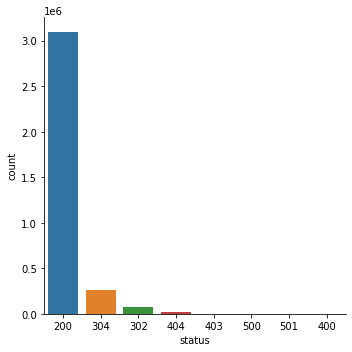

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
sns.catplot(x='status',y='count',data=status_freq_pdf,kind='bar',order=status_freq_pdf['status'])

In [ ]:
status_freq_pdf['log_count']=np.log(status_freq_pdf['count'])
status_freq_pdf

,status,count,log_count
0,200,3100524,14.947082
2,304,266773,12.494153
1,302,73070,11.199173
5,404,20899,9.947457
4,403,225,5.416100
6,500,65,4.174387
7,501,41,3.713572
3,400,15,2.708050


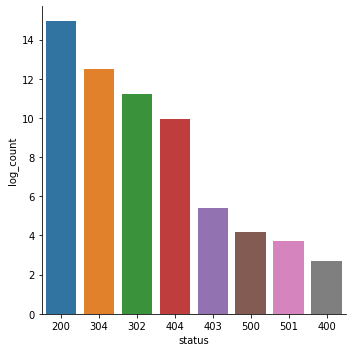

In [ ]:
sns.catplot(x='status',y='log_count',data=status_freq_pdf,kind='bar',order=status_freq_pdf['status'])

**Top 10 Host**

In [ ]:
host_sum_df=logs_df.groupBy('host').count().sort('count',ascending=False).limit(10)
host_sum_df.show(truncate=False)

+--------------------+-----+
|host                |count|
+--------------------+-----+
|piweba3y.prodigy.com|21988|
|piweba4y.prodigy.com|16437|
|piweba1y.prodigy.com|12825|
|edams.ksc.nasa.gov  |11964|
|163.206.89.4        |9697 |
|news.ti.com         |8161 |
|www-d1.proxy.aol.com|8047 |
|alyssa.prodigy.com  |8037 |
|                    |7660 |
|siltb10.orl.mmc.com |7573 |
+--------------------+-----+



**Top 10 end points**

In [ ]:
url_sum_df=logs_df.groupBy('url').count().sort('count',ascending=False).limit(10)
url_sum_df.show(truncate=False)

+---------------------------------------+------+
|url                                    |count |
+---------------------------------------+------+
|/images/NASA-logosmall.gif             |208714|
|/images/KSC-logosmall.gif              |164970|
|/images/MOSAIC-logosmall.gif           |127908|
|/images/USA-logosmall.gif              |127074|
|/images/WORLD-logosmall.gif            |125925|
|/images/ksclogo-medium.gif             |121572|
|/ksc.html                              |83909 |
|/images/launch-logo.gif                |76006 |
|/history/apollo/images/apollo-logo1.gif|68896 |
|/shuttle/countdown/                    |64736 |
+---------------------------------------+------+



**Top 10 error endpoints**

In [ ]:
error_url_sum_df=logs_df.filter(logs_df['status']!=200).groupBy('url').count().sort('count',ascending=False).limit(10)
error_url_sum_df.show(truncate=False)

+---------------------------------------+-----+
|url                                    |count|
+---------------------------------------+-----+
|/images/NASA-logosmall.gif             |40082|
|/images/KSC-logosmall.gif              |23763|
|/images/MOSAIC-logosmall.gif           |15245|
|/images/USA-logosmall.gif              |15142|
|/images/WORLD-logosmall.gif            |14773|
|/images/ksclogo-medium.gif             |13559|
|/images/launch-logo.gif                |8806 |
|/history/apollo/images/apollo-logo1.gif|7489 |
|/                                      |6296 |
|/images/ksclogosmall.gif               |5669 |
+---------------------------------------+-----+



**Unique hosts**

In [ ]:
unique_host_count=logs_df.select('host').distinct().count()
unique_host_count

137933

## Average daily requests per host

In [ ]:
from pyspark.sql.functions import dayofmonth,hour,month
#default max rows to show
def_mr = pd.get_option('max_rows')
#set max rows to 10
pd.set_option('max_rows', 10)

host_day_df=logs_df.select(logs_df['host'],dayofmonth('time').alias('day'))
host_day_df=host_day_df.groupBy('host','day').count().sort('count',ascending=False)
daily_host_df=host_day_df.groupBy('day').count().select('day',col('count').alias('total_hosts'))
daily_request_df=logs_df.select(logs_df['host'],dayofmonth('time').alias('day')).groupBy('day').count().select('day',col('count').alias('total_reqs'))
avg_daily_reqests_per_host_df = daily_request_df.join(daily_host_df, 'day')
avg_daily_reqests_per_host_df = (avg_daily_reqests_per_host_df
                                    .withColumn('avg_reqs', col('total_reqs') / col('total_hosts'))
                                    .sort("day"))
avg_daily_reqests_per_host_df = avg_daily_reqests_per_host_df.toPandas()
avg_daily_reqests_per_host_df

,day,total_reqs,total_hosts,avg_reqs
0,1,98710,7609,12.972795
1,2,60265,4858,12.405311
2,3,130972,10238,12.792733
3,4,130009,9411,13.814579
4,5,126468,9640,13.119087
...,...,...,...,...
26,27,94503,6846,13.804119
27,28,82617,6090,13.566010
28,29,67988,4825,14.090777
29,30,80641,5265,15.316429


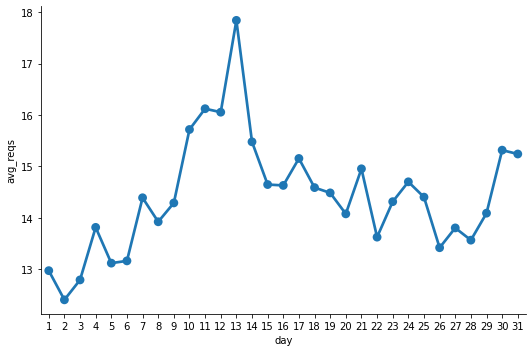

In [ ]:
sns.catplot(x='day', y='avg_reqs', 
                data=avg_daily_reqests_per_host_df, 
                kind='point', height=5, aspect=1.5)

## 404 Response codes analysis

In [ ]:
not_found_df = logs_df.filter(logs_df["status"] == 404).cache()
print(('Total 404 responses: {}').format(not_found_df.count()))

Total 404 responses: 20899


In [ ]:
top20_404_count_df = (not_found_df
                          .groupBy("url")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

top20_404_count_df.show(truncate=False)

+-----------------------------------------------------------------+-----+
|url                                                              |count|
+-----------------------------------------------------------------+-----+
|/pub/winvn/readme.txt                                            |2004 |
|/pub/winvn/release.txt                                           |1732 |
|/shuttle/missions/STS-69/mission-STS-69.html                     |683  |
|/shuttle/missions/sts-68/ksc-upclose.gif                         |428  |
|/history/apollo/a-001/a-001-patch-small.gif                      |384  |
|/history/apollo/sa-1/sa-1-patch-small.gif                        |383  |
|/://spacelink.msfc.nasa.gov                                      |381  |
|/images/crawlerway-logo.gif                                      |374  |
|/elv/DELTA/uncons.htm                                            |372  |
|/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif|359  |
|/images/nasa-logo.gif                

In [ ]:
top20_hosts_404_count_df = (not_found_df
                          .groupBy("host")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

top20_hosts_404_count_df.show(truncate=False)

+---------------------------+-----+
|host                       |count|
+---------------------------+-----+
|hoohoo.ncsa.uiuc.edu       |251  |
|piweba3y.prodigy.com       |157  |
|jbiagioni.npt.nuwc.navy.mil|132  |
|piweba1y.prodigy.com       |114  |
|                           |112  |
|www-d4.proxy.aol.com       |91   |
|piweba4y.prodigy.com       |86   |
|scooter.pa-x.dec.com       |69   |
|www-d1.proxy.aol.com       |64   |
|phaelon.ksc.nasa.gov       |64   |
|dialip-217.den.mmc.com     |62   |
|www-b4.proxy.aol.com       |62   |
|www-b3.proxy.aol.com       |61   |
|www-a2.proxy.aol.com       |60   |
|www-d2.proxy.aol.com       |59   |
|piweba2y.prodigy.com       |59   |
|alyssa.prodigy.com         |56   |
|monarch.eng.buffalo.edu    |56   |
|www-b2.proxy.aol.com       |53   |
|www-c4.proxy.aol.com       |53   |
+---------------------------+-----+



In [ ]:
errors_by_date_sorted_df = (not_found_df
                                .groupBy(dayofmonth('time').alias('day'))
                                .count()
                                .sort("day"))

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()
errors_by_date_sorted_pd_df

,day,count
0,1,559
1,2,291
2,3,778
3,4,705
4,5,733
...,...,...
26,27,706
27,28,504
28,29,420
29,30,571


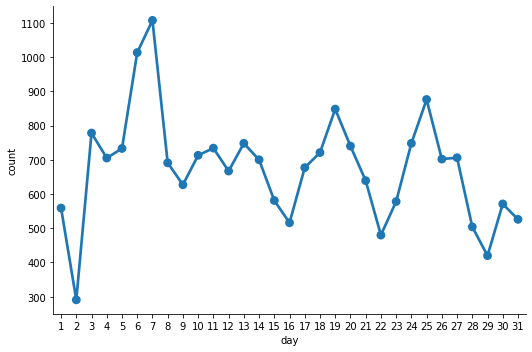

In [ ]:
 sns.catplot(x='day', y='count', 
                data=errors_by_date_sorted_pd_df, 
                kind='point', height=5, aspect=1.5)

In [ ]:
errors_by_date_sorted_df.sort("count", ascending=False).show(3)

+---+-----+
|day|count|
+---+-----+
|  7| 1107|
|  6| 1013|
| 25|  876|
+---+-----+
only showing top 3 rows



In [ ]:
hourly_avg_errors_sorted_df = (not_found_df
                                   .groupBy(hour('time')
                                             .alias('hour'))
                                   .count()
                                   .sort('hour'))
hourly_avg_errors_sorted_pd_df = hourly_avg_errors_sorted_df.toPandas()

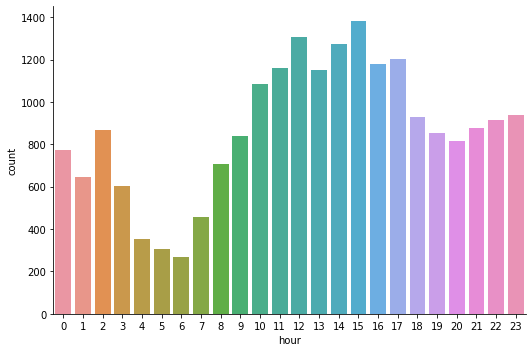

In [ ]:
sns.catplot(x='hour', y='count', 
                data=hourly_avg_errors_sorted_pd_df, 
                kind='bar', height=5, aspect=1.5)

In [ ]:
hourly_avg_errors_sorted_df.sort("count", ascending=False).show(3)

+----+-----+
|hour|count|
+----+-----+
|  15| 1382|
|  12| 1308|
|  14| 1274|
+----+-----+
only showing top 3 rows



In [ ]:
#reset max rows displayed in pandas
pd.set_option('max_rows', def_mr)